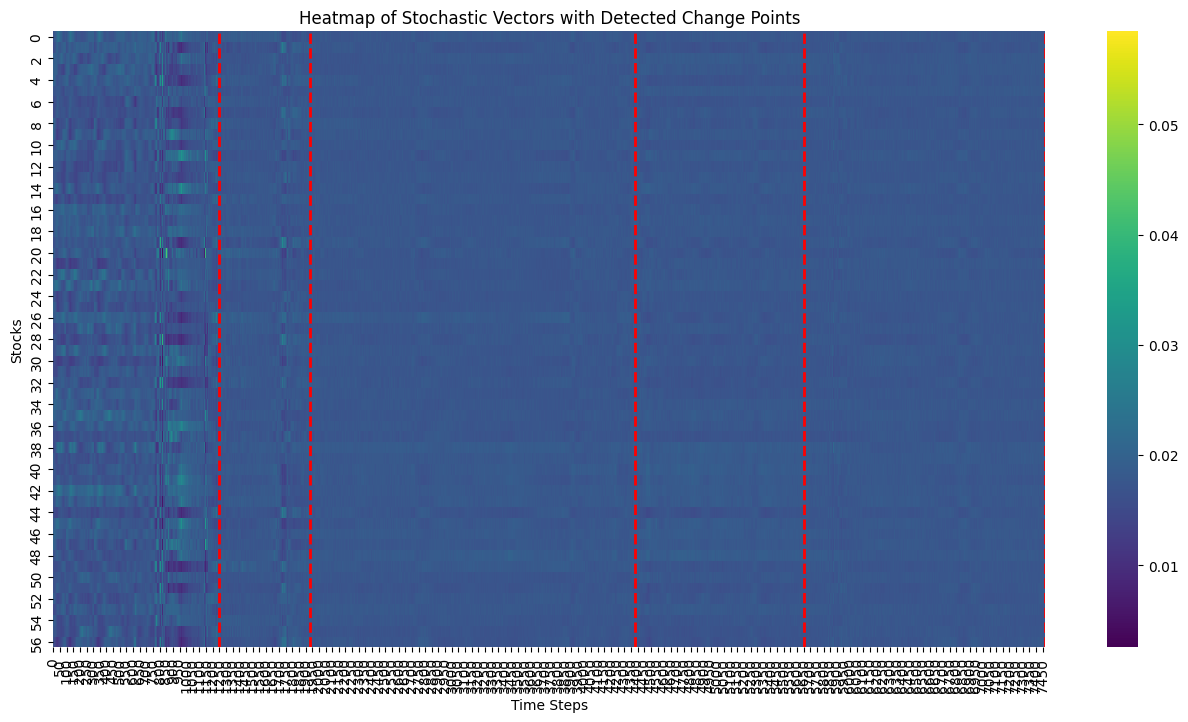

In [1]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'data/model/agent_actions.csv'
data = pd.read_csv(file_path, index_col=0)

stochastic_vectors = data.values
model = rpt.KernelCPD(kernel="rbf", min_size=5, jump=1).fit(stochastic_vectors)
predicted_breakpoints = model.predict(n_bkps=4)

# Step 4: Plotting the heatmap of the stochastic vectors
plt.figure(figsize=(16, 8))
sns.heatmap(stochastic_vectors.T, cmap="viridis", cbar=True, xticklabels=50)
for bp in predicted_breakpoints:
    plt.axvline(x=bp, color='red', linestyle='--', lw=2)
plt.title("Heatmap of Stochastic Vectors with Detected Change Points")
plt.xlabel("Time Steps")
plt.ylabel("Stocks")
plt.show()

In [1]:
from bcb import sgs

# Test fetching SELIC with the correct code
selic_data = sgs.get(('selic', 432), start='2005-01-01')
print(selic_data)


            selic
Date             
2005-01-01  17.75
2005-01-02  17.75
2005-01-03  17.75
2005-01-04  17.75
2005-01-05  17.75
...           ...
2024-10-10  10.75
2024-10-11  10.75
2024-10-12  10.75
2024-10-13  10.75
2024-10-14  10.75

[7227 rows x 1 columns]
